In [1]:
import sys
sys.path.append('..')

import torch
import torchvision.models as models
import torchvision.transforms as transforms
from transformers import BertTokenizer

from core.dataset import HatefulMemesDataset
from core.model import HateMemeModel, PretrainedModel

In [2]:
train_dataset = HatefulMemesDataset('/Users/nstanishev/Workspace/epfl/04/dl/project/data/data/train.jsonl')
val_dataset = HatefulMemesDataset('/Users/nstanishev/Workspace/epfl/04/dl/project/data/data/dev.jsonl')
test_dataset = HatefulMemesDataset('/Users/nstanishev/Workspace/epfl/04/dl/project/data/data/test.jsonl')

In [3]:
len(train_dataset), len(val_dataset), len(test_dataset)

(8500, 500, 1000)

In [4]:
train_dataset[0]

(<PIL.PngImagePlugin.PngImageFile image mode=RGB size=265x400>,
 'its their character not their color that matters',
 0)

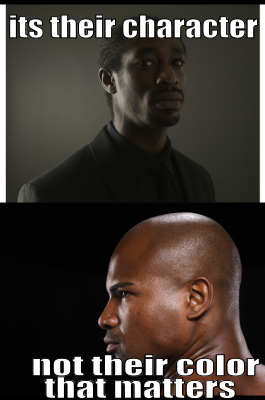

In [5]:
train_dataset[0][0]

In [6]:
model = HateMemeModel(PretrainedModel.load_bert_text_model(), PretrainedModel.load_resnet_image_model())

/Users/nstanishev/opt/anaconda3/envs/epfl-dl/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/nstanishev/opt/anaconda3/envs/epfl-dl/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/nstanishev/opt/anaconda3/envs/epfl-dl/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
model

HateMemeModel(
  (text_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [8]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [9]:
img = transform(train_dataset[0][0])
text = tokenizer(train_dataset[0][1], return_tensors='pt')
label = torch.tensor(train_dataset[0][2])

In [10]:
PretrainedModel.load_bert_text_model()(**text).pooler_output.shape

torch.Size([1, 768])

In [11]:
image_features = PretrainedModel.load_resnet_image_model()(img.unsqueeze(0))
image_features.view(image_features.size(0), -1).shape

torch.Size([1, 2048])

In [12]:
model(text, img.unsqueeze(0))

tensor([[-0.0053,  0.0814]], grad_fn=<AddmmBackward0>)